In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import QuantileTransformer

In [2]:
data = pd.read_csv(r"C:\Zhongming Lu\hk_bld\eui\final data\hk_eui_sample_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data = data.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data = data[ (data.highrise_j>0) | (data.podium_j>0) ]
data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]
data = data[(data.Year_Built>0) & (data.No_of_Stor>0)]

In [3]:
data['Area'] = np.where(data['highrise'] == 1, data['highrise_a'], data['podium_are'])

In [4]:
data['retro_before'] = np.where(data['retro']=='Before',1,0)
data['retro_after'] = np.where(data['retro']=='After',1,0)

In [5]:
data['log_area'] = np.log10(data['Area']+1)
data['log_hotel_kern'] = np.log10(data['hotel_kern']+1)
data['log_retail_ker'] = np.log10(data['retail_ker']+1)
data['log_parking_ke'] = np.log10(data['parking_ke']+1)
data['log_food_kerne'] = np.log10(data['food_kerne']+1)
data['log_office_ker'] = np.log10(data['office_ker']+1)

In [6]:
data['log_mtr_dist'] = np.log10(data['mtr_dist'])

In [7]:
data['commercial'] = np.where(data['RASTERVALU']==11,1,0)

In [8]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [9]:
log_y = np.log10(y)

In [10]:
log_eui_median = log_y.median()
log_eui_median

1.778729923996112

In [138]:
#log_y_reshape = log_y.to_numpy().reshape(-1,1)

In [139]:
#qt = QuantileTransformer(n_quantiles = 20, output_distribution = 'normal', random_state= 8000)
#log_y_transform = qt.fit_transform(log_y_reshape)

In [140]:
#log_y_transform_s = pd.Series(log_y_transform.flatten())

In [11]:
log_y_category = pd.cut(log_y, bins=5)

In [12]:
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [143]:
#Weight adjustment
#for i in range(len(log_y)):
#    if log_y[i]<=1.2 or log_y[i]>2.25:
#        log_y_weight[i] = log_y_weight[i]*32
#    elif log_y[i]>1.70 and log_y[i]<1.90:
#        log_y_weight[i] = log_y_weight[i]/16
#    else:
#        log_y_weight[i] = log_y_weight[i]*6

In [13]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [14]:
seed = 8000

In [15]:
ols = LinearRegression()

In [16]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, log_y), range(10)):
    ols.fit(X.iloc[train], log_y.iloc[train],sample_weight=log_y_weight[train])
    log_y_pred = ols.predict(X.iloc[test])
    log_y_true = log_y.loc[test].values

    accuracy_num = 0 
    
    for i in range(len(log_y_pred)):
        if log_y_true[i] > log_eui_median:
            if log_y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if log_y_true[i] <= log_eui_median:
            if log_y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = metrics.mean_squared_error(log_y.iloc[test], log_y_pred, squared=False)
    r2_test = metrics.r2_score(log_y.loc[test],log_y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(log_y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3395
R2: 0.1725
Accuracy:  70.95%
RMSE: 0.3339
R2: 0.1762
Accuracy:  70.95%
RMSE: 0.3191
R2: 0.2633
Accuracy:  74.76%
RMSE: 0.3085
R2: 0.2994
Accuracy:  70.95%
RMSE: 0.3060
R2: 0.2460
Accuracy:  72.25%


In [17]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300

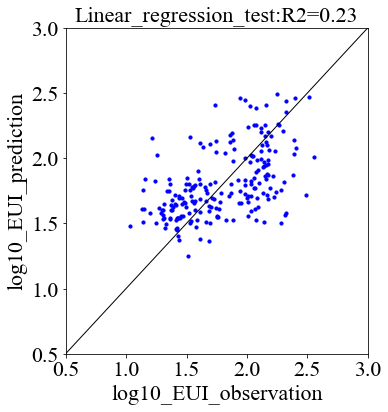

In [18]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(log_y.iloc[test], log_y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("Linear_regression_test:R2=0.23", fontsize=22)
#ax.annotate('R2=0.31',(1.5,2.5), fontsize=22)
#ax.set_title("%f Error Plot"%(r2_score(log_y.iloc[test],log_y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(mean_squared_error(log_y_transform_s,log_y_transform_pred,squared=False)), fontsize=17)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\linear_regression_test.png')

plt.show()
plt.close()

In [124]:
#ols.fit(X_reset, log_y_reset)
log_y_pred = ols.predict(X)
#log_y_pred = qt.inverse_transform(log_y_transform_pred.reshape(-1,1))

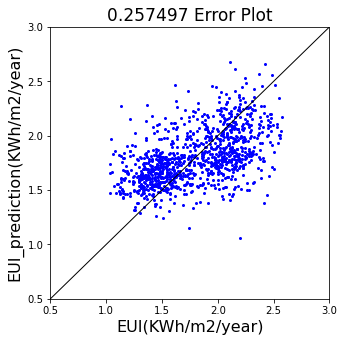

In [125]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(log_y, log_y_pred, color='b', s=4, label="Predicted")    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.set_title("%f Error Plot"%(metrics.r2_score(log_y,log_y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(metrics.mean_squared_error(log_y_reset,log_y_pred,squared=False)), fontsize=17)
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=16)
ax.set_ylabel("EUI_prediction(KWh/m2/year)", fontsize=16)
plt.show()
plt.close()

In [126]:
ols.coef_

array([ 0.0143474 , -0.02401127,  0.05311908, -0.00570783,  0.06262305,
       -0.26241438, -0.02809994,  0.29778718,  0.29719991,  0.00150542,
        0.00812818,  0.18692298,  0.17419168, -0.13338663, -0.05217396])

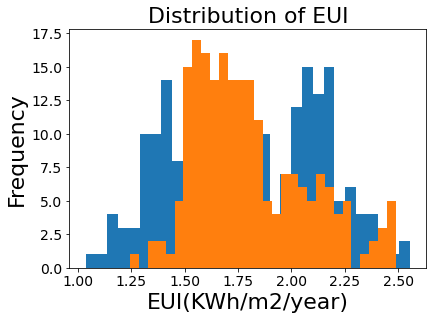

In [149]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
#mu, sigma = y.mean(), y.std()
#bins = np.logspace(np.log10(1),np.log10(y.max()),50) 
#plt.hist(y, bins=bins)
plt.hist(log_y_true,bins=30)
plt.hist(log_y_pred,bins=30)
#plt.xscale("log")

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()